# Hypothesis

#####  Higher production budgets are associated with higher revenues but have a weak relationship with user ratings; additionally, director experience and genre influence both ratings and revenue patterns.

# Data Cleaning

### Data cleaning prepares the raw TMDB datasets for robust analysis and plotting. The main goals are:
- Ensure key fields are present and usable (budget, revenue, runtime, ratings).
- Transform nested JSON-like columns (genres, cast, crew) into analytical features.
- Identify and handle missingness and structural zeros that could bias results.


In [1]:
import pandas as pd
import numpy as np
import ast
from IPython.display import display

pd.set_option("display.max_colwidth", 200)

movies_df  = pd.read_csv("archive/tmdb_5000_movies.csv")
credits_df = pd.read_csv("archive/tmdb_5000_credits.csv")

print("movies_df.shape:", movies_df.shape)
print("credits_df.shape:", credits_df.shape)


movies_df.shape: (4803, 20)
credits_df.shape: (4803, 4)


##### We import core libraries (pandas, numpy, ast) and load the two TMDB files:
- tmdb_5000_movies.csv: movie-level attributes (budget, revenue, genres, runtime, etc.).
- tmdb_5000_credits.csv: cast and crew details.

The printed shapes confirm both files contain 4,803 rows, which signals a one-to-one join is feasible on the movie ID fields. This parity helps avoid row loss during merging.


In [2]:
display(movies_df.head(2))
display(credits_df.head(2))

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id""...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""credit_id"": ""5602a8a7c3a3685532001c9a"", ""gender"": 2, ""id"": 65731, ""name"": ""Sam Worthington"", ""order"": 0}, {""cast_id"": 3, ""character"": ""Neytiri"", ""cred...","[{""credit_id"": ""52fe48009251416c750aca23"", ""department"": ""Editing"", ""gender"": 0, ""id"": 1721, ""job"": ""Editor"", ""name"": ""Stephen E. Rivkin""}, {""credit_id"": ""539c47ecc3a36810e3001f87"", ""department"": ..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Sparrow"", ""credit_id"": ""52fe4232c3a36847f800b50d"", ""gender"": 2, ""id"": 85, ""name"": ""Johnny Depp"", ""order"": 0}, {""cast_id"": 5, ""character"": ""Will Turner"", ...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""department"": ""Camera"", ""gender"": 2, ""id"": 120, ""job"": ""Director of Photography"", ""name"": ""Dariusz Wolski""}, {""credit_id"": ""52fe4232c3a36847f800b4fd"", ""d..."


##### Ensuring row parity early prevents accidental duplication or loss during the merge of movies and credits.


In [3]:
def missing_table(df):
    n = len(df)
    miss = df.isna().sum()
    pct = (miss / n * 100).round(2)
    return pd.DataFrame({"missing": miss, "missing_%": pct}).sort_values("missing", ascending=False)

def zero_table_all_numeric(df):
    num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
    zero_counts = ((df[num_cols_all] == 0).sum()).sort_values(ascending=False)
    return zero_counts.to_frame("zeros")


##### This helper cell defines two reusable diagnostic functions for data quality checks:

- missing_table(df):
  - Computes the count and percentage of missing (NaN) values for every column in the DataFrame df.
  - Returns a tidy table with two columns — missing (absolute count) and missing_% (percentage of rows) — sorted by the highest number of missing entries. This helps prioritize which fields to clean, drop, or ignore in downstream analysis.

- zero_table_all_numeric(df):
  - Selects all numeric columns in df and counts how many zero values each contains.
  - Returns a one-column table (zeros) sorted in descending order of zero counts. This is crucial for identifying “structural zeros” (e.g., budget or revenue recorded as 0 when truly unknown), which can bias averages, correlations, and plots unless filtered out.


In [4]:
print("Missing values in movies_df:")
display(missing_table(movies_df).head(30))


Missing values in movies_df:


,missing,missing_%
homepage,3091,64.36
tagline,844,17.57
overview,3,0.06
runtime,2,0.04
release_date,1,0.02
id,0,0.00
budget,0,0.00
genres,0,0.00
original_title,0,0.00
popularity,0,0.00


##### This cell reports missing values in movies_df. Using missing_table, it shows each column’s NaN count and percentage (top 30), helping decide which fields to drop, ignore, or clean before analysis.


In [5]:
print("Zero counts in all numeric columns (movies_df):")
display(zero_table_all_numeric(movies_df))

display(movies_df[movies_df["revenue"] == 0][["id","title","budget","revenue","runtime"]].head())


Zero counts in all numeric columns (movies_df):


,zeros
revenue,1427
budget,1037
vote_average,63
vote_count,62
runtime,35
popularity,1
id,0


,id,title,budget,revenue,runtime
83,79698,The Lovers,27000000,0,109.0
135,7978,The Wolfman,150000000,0,102.0
265,10588,The Cat in the Hat,0,0,82.0
309,10214,Son of the Mask,84000000,0,94.0
376,10357,Volcano,90000000,0,104.0


##### This cell checks for “structural zeros” that can bias financial analysis. It lists zero counts for all numeric columns, then shows sample rows with revenue==0 to verify that many titles report unknown revenue as 0. We’ll filter out budget==0 or revenue==0 in money-based analyses.


In [6]:
print("Missing values in credits_df:")
display(missing_table(credits_df).head(30))

print("\nDuplicate ID counts:")
print("movies_df id duplicates:", movies_df["id"].duplicated().sum())
print("credits_df movie_id duplicates:", credits_df["movie_id"].duplicated().sum())

print("\nID alignment (fractions):")
print("share of movies with a credits row:", movies_df["id"].isin(credits_df["movie_id"]).mean())
print("share of credits with a movie row:  ", credits_df["movie_id"].isin(movies_df["id"]).mean())


Missing values in credits_df:


,missing,missing_%
movie_id,0,0.0
title,0,0.0
cast,0,0.0
crew,0,0.0



Duplicate ID counts:
movies_df id duplicates: 0
credits_df movie_id duplicates: 0

ID alignment (fractions):
share of movies with a credits row: 1.0
share of credits with a movie row:   1.0


##### This cell audits credits_df quality and ID consistency. It:
- Reports missing values in credits_df (top 30) using missing_table.
- Checks duplicate IDs in movies_df.id and credits_df.movie_id (should be zero for a clean 1–1 merge).
- Verifies alignment between files by computing the fraction of movies with a matching credits row and vice versa, confirming join completeness.


In [7]:
df = movies_df.merge(credits_df, left_on="id", right_on="movie_id", how="inner")
df = df.drop(columns=["movie_id", "title_y"]).rename(columns={"title_x": "title"})
print("Merged df.shape:", df.shape)

df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

print("\nMissing values after merge (top 20):")
display(missing_table(df).head(20))

print("\nZero counts after merge (all numeric columns):")
display(zero_table_all_numeric(df))


Merged df.shape: (4803, 22)

Missing values after merge (top 20):


,missing,missing_%
homepage,3091,64.36
tagline,844,17.57
overview,3,0.06
runtime,2,0.04
release_date,1,0.02
budget,0,0.00
original_language,0,0.00
keywords,0,0.00
id,0,0.00
genres,0,0.00



Zero counts after merge (all numeric columns):


,zeros
revenue,1427
budget,1037
vote_average,63
vote_count,62
runtime,35
popularity,1
id,0


##### Audits credits_df and ID alignment:
- Missing values in credits_df (top 30) via missing_table.
- Duplicate checks for movies_df.id and credits_df.movie_id (expect 0 for a clean 1–1 merge).
- Join completeness: share of movies with credits and share of credits with movies.


In [8]:
rev0_count = int((df["revenue"] == 0).sum())
print("Rows with revenue == 0 (will be dropped):", rev0_count)

display(df[df["revenue"] == 0][["id","title","budget","revenue","release_date"]].head())


Rows with revenue == 0 (will be dropped): 1427


,id,title,budget,revenue,release_date
83,79698,The Lovers,27000000,0,2015-02-13
135,7978,The Wolfman,150000000,0,2010-02-11
265,10588,The Cat in the Hat,0,0,2003-11-21
309,10214,Son of the Mask,84000000,0,2005-02-18
376,10357,Volcano,90000000,0,1997-04-25


##### Counts and previews rows with revenue==0. These are treated as unknowns and will be dropped before any money-based analysis to avoid bias. The sample table helps sanity-check the entries being removed.


In [9]:
n_before = len(df)
df = df[df["revenue"] > 0].copy()
n_after_drop_rev = len(df)
print(f"Rows before: {n_before} | after dropping revenue==0: {n_after_drop_rev} | dropped: {n_before - n_after_drop_rev}")


Rows before: 4803 | after dropping revenue==0: 3376 | dropped: 1427


##### Filters out rows with revenue==0 to prevent bias in financial analyses. The printout summarizes how many rows were kept vs. dropped.


In [10]:
if "runtime" in df.columns:
    invalid_runtime = int((df["runtime"] <= 0).sum())
    print("Count runtime <= 0 (will be treated as missing):", invalid_runtime)
    df.loc[df["runtime"] <= 0, "runtime"] = np.nan
else:
    print("No runtime column found.")


Count runtime <= 0 (will be treated as missing): 1


##### Validates runtime quality. Counts entries with runtime<=0, treats them as missing by setting to NaN, ensuring duration-based analyses aren’t skewed by invalid values.


In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["id"]]

medians = df[numeric_cols].median()
print("Medians (sample):")
display(medians.sort_values(ascending=False).head(15))

df[numeric_cols] = df[numeric_cols].fillna(medians)
print("Total numeric NaNs after imputation:", int(df[numeric_cols].isna().sum().sum()))


Medians (sample):


revenue         5.175184e+07
budget          2.500000e+07
vote_count      4.405000e+02
runtime         1.060000e+02
popularity      1.975522e+01
vote_average    6.300000e+00
dtype: float64

Total numeric NaNs after imputation: 0


##### Imputes missing numeric values with medians to keep rows usable without skewing distributions. We:
- Select numeric columns (excluding the identifier id).
- Compute and preview column medians.
- Fill NaNs in numeric columns with these medians.
- Confirm imputation by reporting total remaining numeric NaNs (should be 0).


In [12]:
drop_text_cols = ["overview", "tagline", "homepage"]
print("Attempting to drop these text columns (if present):", drop_text_cols)
print("Existing among them before drop:", [c for c in drop_text_cols if c in df.columns])

df = df.drop(columns=drop_text_cols, errors="ignore")
print("Columns after dropping text cols (sample):", list(df.columns)[:30])


Attempting to drop these text columns (if present): ['overview', 'tagline', 'homepage']
Existing among them before drop: ['overview', 'tagline', 'homepage']
Columns after dropping text cols (sample): ['budget', 'genres', 'id', 'keywords', 'original_language', 'original_title', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'vote_average', 'vote_count', 'cast', 'crew']


##### Removes non-analytical text fields (overview, tagline, homepage) to reduce noise and memory. Prints which of these existed and confirms the remaining columns after drop.


In [13]:
missing_dates_before = int(df["release_date"].isna().sum())
print("Missing release_date before drop:", missing_dates_before)

df = df.dropna(subset=["release_date"]).copy()
df["release_year"] = df["release_date"].dt.year

print("Shape after dropping missing release_date:", df.shape)


Missing release_date before drop: 0
Shape after dropping missing release_date: (3376, 20)


##### Drops rows with missing release_date to enable time-based analyses, then derives release_year from release_date. Prints missing count before drop and the post-drop shape for traceability.


In [14]:
def _safe_eval(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

def _genre_names(genres_str):
    items = _safe_eval(genres_str)
    return [d.get("name") for d in items if isinstance(d, dict) and "name" in d]

def _primary_genre(genres_str):
    names = _genre_names(genres_str)
    return names[0] if names else None

def _num_actors(cast_str):
    return len(_safe_eval(cast_str))

def _director(crew_str):
    for d in _safe_eval(crew_str):
        if isinstance(d, dict) and d.get("job") == "Director":
            return d.get("name")
    return None


##### Helper parsers for nested JSON-like columns:
- _safe_eval: safely parses stringified lists/dicts; returns [] on failure.
- _genre_names: extracts genre names from genres.
- _primary_genre: first genre name (used as primary genre).
- _num_actors: counts cast entries.
- _director: finds the crew member with job == "Director".


In [15]:
df["genres_list"]   = df["genres"].apply(_genre_names)
df["primary_genre"] = df["genres"].apply(_primary_genre)
df["num_actors"]    = df["cast"].apply(_num_actors)
df["director"]      = df["crew"].apply(_director)

display(df[["title","budget","revenue","runtime","primary_genre","num_actors","director","release_year"]].head(12))


,title,budget,revenue,runtime,primary_genre,num_actors,director,release_year
0,Avatar,237000000,2787965087,162.0,Action,83,James Cameron,2009
1,Pirates of the Caribbean: At World's End,300000000,961000000,169.0,Adventure,34,Gore Verbinski,2007
2,Spectre,245000000,880674609,148.0,Action,83,Sam Mendes,2015
3,The Dark Knight Rises,250000000,1084939099,165.0,Action,158,Christopher Nolan,2012
4,John Carter,260000000,284139100,132.0,Action,27,Andrew Stanton,2012
5,Spider-Man 3,258000000,890871626,139.0,Fantasy,143,Sam Raimi,2007
6,Tangled,260000000,591794936,100.0,Animation,13,Byron Howard,2010
7,Avengers: Age of Ultron,280000000,1405403694,141.0,Action,72,Joss Whedon,2015
8,Harry Potter and the Half-Blood Prince,250000000,933959197,153.0,Adventure,49,David Yates,2009
9,Batman v Superman: Dawn of Justice,250000000,873260194,151.0,Action,152,Zack Snyder,2016


Extracts analysis-ready features from nested columns:
- genres_list: all genre names.
- primary_genre: first listed genre.
- num_actors: cast size.
- director: name of the credited Director.
Displays a quick preview of these features alongside core fields for validation.


In [16]:
assert (df["revenue"] > 0).all(), "There are rows with revenue <= 0 remaining."

num_nan_sum = df[numeric_cols].isna().sum().sum()
print("Total numeric NaNs remaining (should be 0):", int(num_nan_sum))

print("\nTop primary genres:")
display(df["primary_genre"].value_counts().head(8))

print("\nTop directors by movie count:")
display(df["director"].value_counts().head(8))

print("\nFinal cleaned dataframe shape:", df.shape)


Total numeric NaNs remaining (should be 0): 0

Top primary genres:


primary_genre
Drama        793
Comedy       675
Action       604
Adventure    293
Horror       206
Crime        144
Thriller     122
Animation    101
Name: count, dtype: int64


Top directors by movie count:


director
Steven Spielberg     27
Clint Eastwood       20
Martin Scorsese      17
Ridley Scott         16
Robert Rodriguez     16
Renny Harlin         15
Tim Burton           14
Steven Soderbergh    14
Name: count, dtype: int64


Final cleaned dataframe shape: (3376, 24)


Final data quality checks and quick summaries:
- Asserts all rows have revenue>0 after filtering.
- Verifies no remaining numeric NaNs post-imputation (should be 0).
- Shows top primary genres and top directors by film count for context.
- Prints the final cleaned dataframe shape.


# Visualization

## Visualization 1 — Distribution of Success

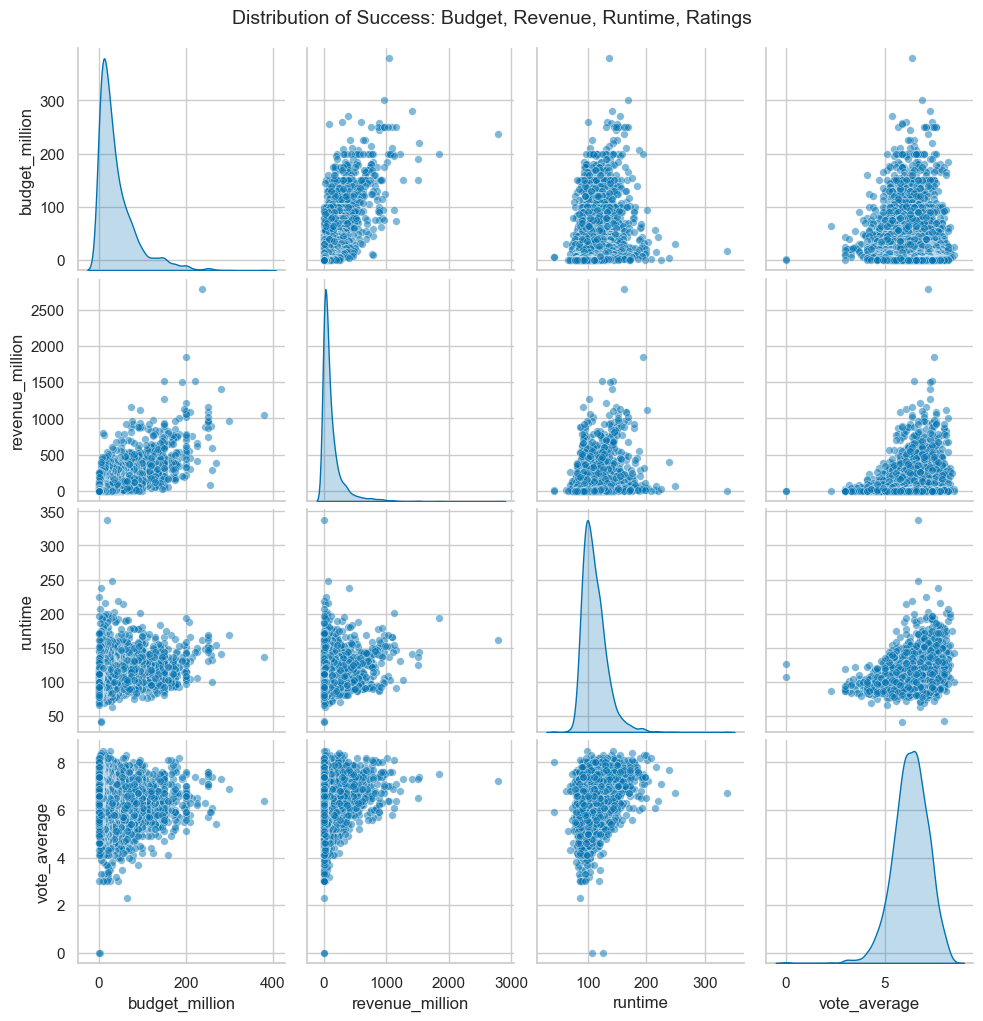

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

pairplot_df = df[["budget", "revenue", "runtime", "vote_average"]].copy()

# Scale to millions for readability
pairplot_df["budget_million"] = pairplot_df["budget"] / 1e6
pairplot_df["revenue_million"] = pairplot_df["revenue"] / 1e6

sns.set_theme(style="whitegrid", palette="colorblind")

g = sns.pairplot(
    pairplot_df,
    vars=["budget_million", "revenue_million", "runtime", "vote_average"],
    corner=False,        # 👈 full plot, both upper & lower triangles
    diag_kind="kde",
    plot_kws={"alpha":0.5, "s":30}
)

plt.suptitle("Distribution of Success: Budget, Revenue, Runtime, Ratings", 
             y=1.02, fontsize=14)

plt.show()


Pairwise view of success drivers:

- Budgets and revenues are shown in millions (USD) for clearer scale.

- Diagonal KDEs illustrate individual distributions; scatter plots in both upper and lower triangles display relationships between variables.

- Key takeaway: strong positive correlation exists between budget and revenue, confirming that higher budgets generally lead to higher revenues. Runtime and ratings remain more weakly associated with financial success.

- This full pair plot provides a complete view of correlations among budget, revenue, runtime, and ratings, highlighting the dominant influence of budget on revenue while showing that runtime and ratings play lesser roles.

## Visualization 2 — Time-Series Analysis

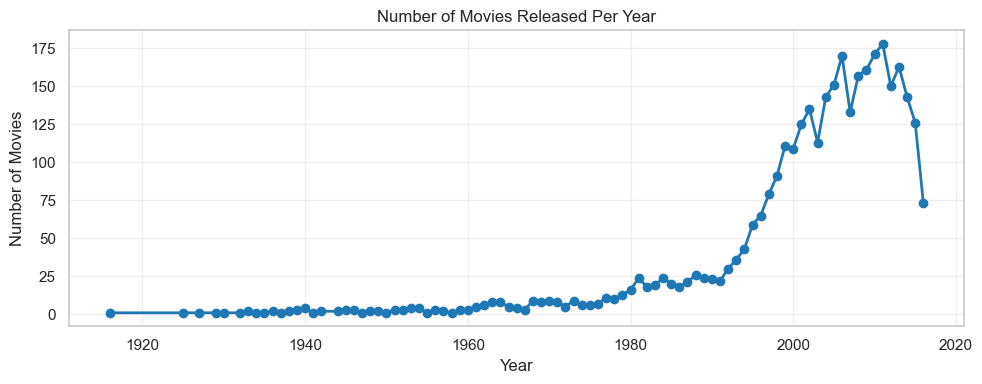

In [18]:
releases_per_year = df.groupby("release_year").size()

plt.figure(figsize=(10,4))
plt.plot(releases_per_year.index, releases_per_year.values, marker="o", linewidth=2, color="tab:blue")
plt.title("Number of Movies Released Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Annual release trend:
- Line plot of movies released per year with clear labels and grid.
- Highlights the long-run rise in production post-1980, with levels peaking around 2010.


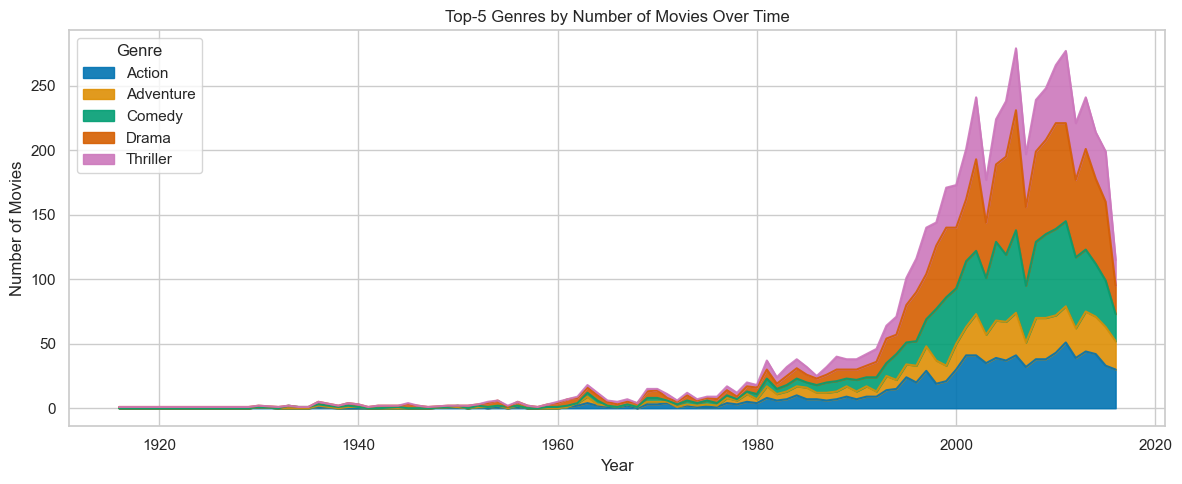

In [19]:
gexp = df.explode("genres_list").dropna(subset=["genres_list"])
top5 = gexp["genres_list"].value_counts().head(5).index.tolist()

yr_genre = (
    gexp[gexp["genres_list"].isin(top5)]
    .groupby(["release_year","genres_list"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(12,5))
yr_genre.plot.area(ax=plt.gca(), alpha=0.9, color=sns.color_palette("colorblind", n_colors=len(top5)))
plt.title("Top-5 Genres by Number of Movies Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.legend(title="Genre", loc="upper left")
plt.tight_layout()
plt.show()


Stacked area: top-5 genres over time
- Shows yearly counts for the most frequent genres using a colorblind-safe palette.
- Clear axes with units and legend; sorted by year for smooth trends.
- Takeaway: Action and Adventure surge post-2000; Drama remains consistently prominent across decades.


## Revenue & Ratings Breakdown

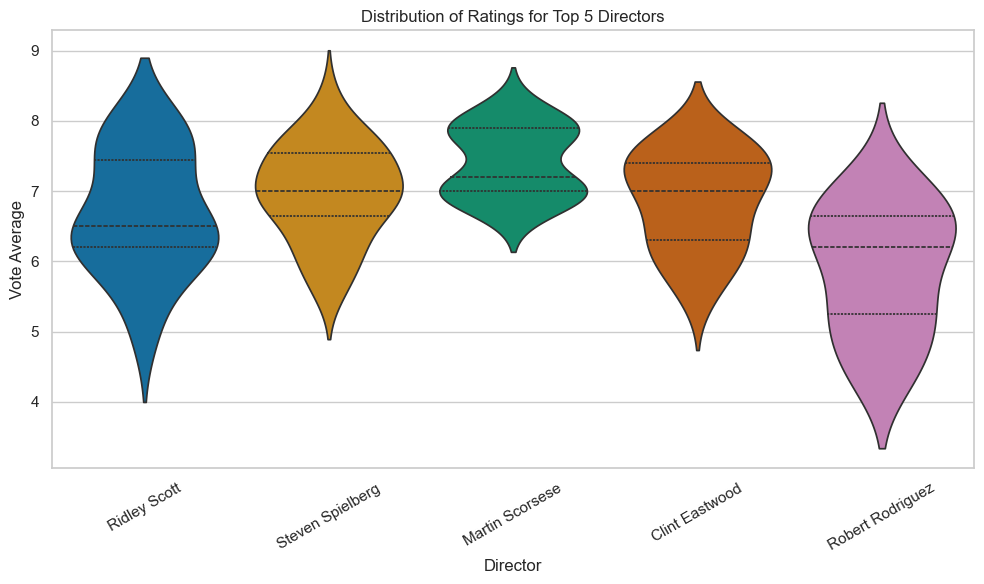

In [20]:
top5_directors = df["director"].value_counts().head(5).index.tolist()
dir_subset = df[df["director"].isin(top5_directors)]

plt.figure(figsize=(10,6))
sns.violinplot(
    data=dir_subset,
    x="director",
    y="vote_average",
    hue="director",       
    palette="colorblind",
    inner="quartile",
    legend=False
)
plt.title("Distribution of Ratings for Top 5 Directors")
plt.xlabel("Director")
plt.ylabel("Vote Average")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Director rating distributions (violin):
- Compares vote_average across the five most prolific directors using colorblind-safe hues.
- Violins with quartiles reveal central tendency and spread; rotated labels improve readability.
- Takeaway: Directors exhibit distinct and sometimes tighter rating distributions, indicating varying consistency in audience reception.


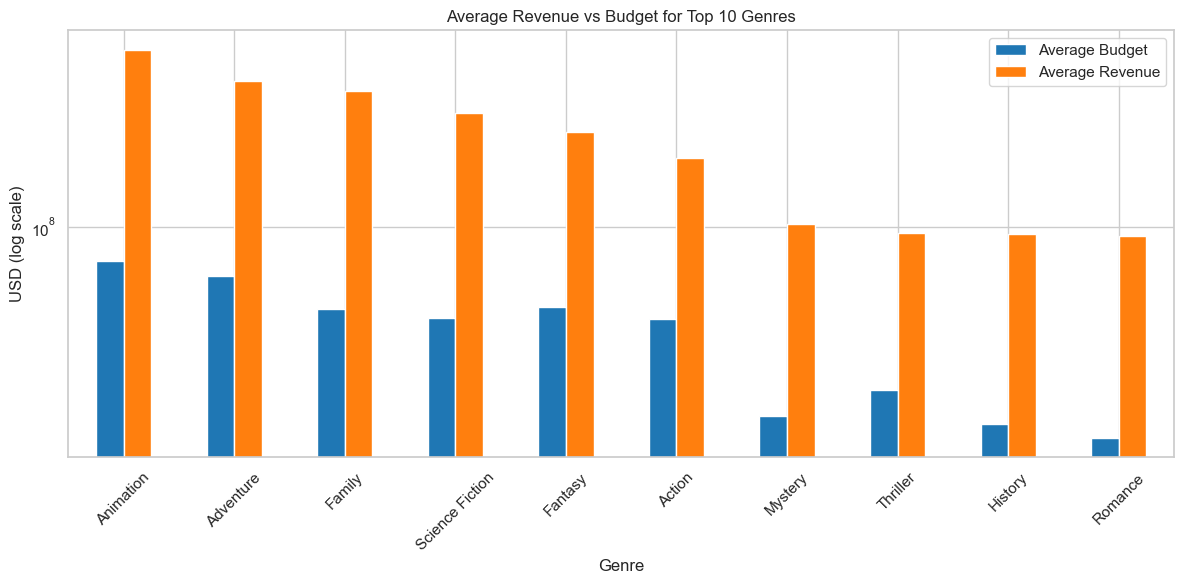

In [21]:
genre_stats = (
    df.groupby("primary_genre")[["budget","revenue"]]
    .mean()
    .sort_values("revenue", ascending=False)
    .head(10)
)

ax = genre_stats.plot.bar(figsize=(12,6), color=["#1f77b4","#ff7f0e"])
plt.title("Average Revenue vs Budget for Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("USD (log scale)")
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(["Average Budget","Average Revenue"])
plt.tight_layout()
plt.show()


Average revenue vs budget by genre:
- Side-by-side bars on a log scale compare average budget and revenue for the top 10 genres.
- Clear labeling, rotated ticks, and legend aid readability; log scale handles heavy skew.
- Takeaway: Action, Adventure, and Animation combine high budgets with high average revenues, indicating strong commercial performance.


## Correlation Matrix

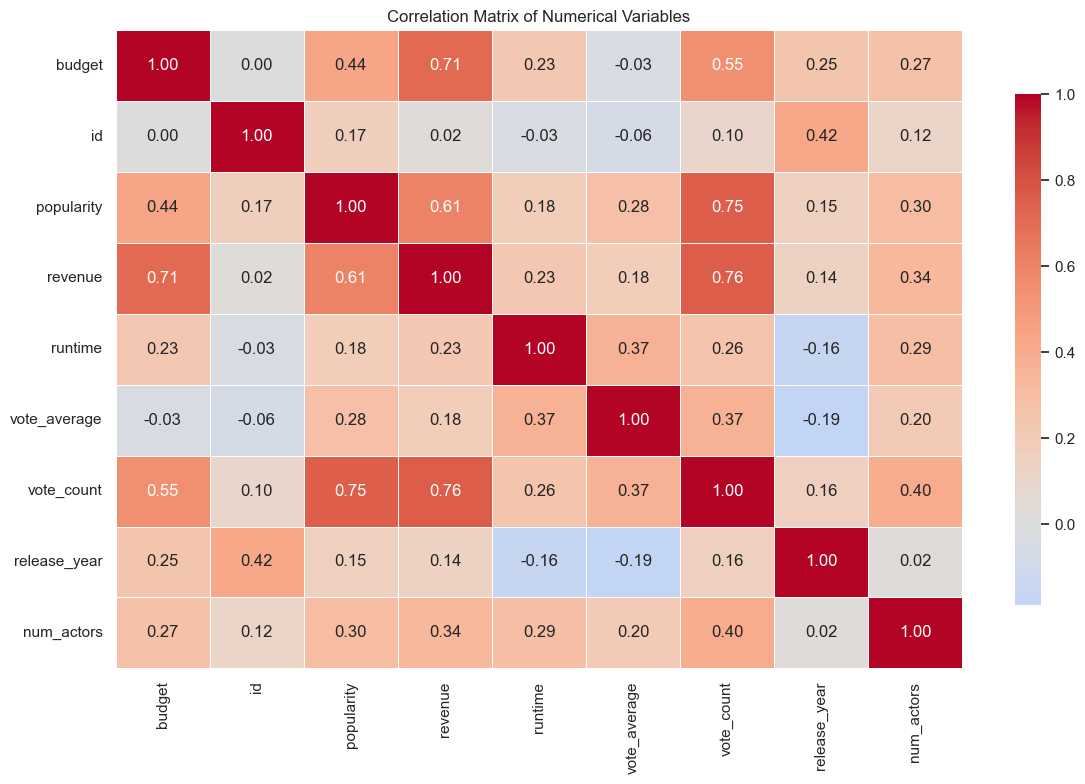

In [22]:
num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink":0.8}
)
plt.title("Correlation Matrix of Numerical Variables")
plt.tight_layout()
plt.show()


Correlation matrix (numerical features):
- Annotated heatmap using a perceptually uniform palette; centered at 0 to show positive vs negative relations.
- Clear title and readable annotations; thin grid lines aid cell separation.
- Takeaway: Revenue correlates strongly with budget; runtime has weak ties to ratings and revenue.


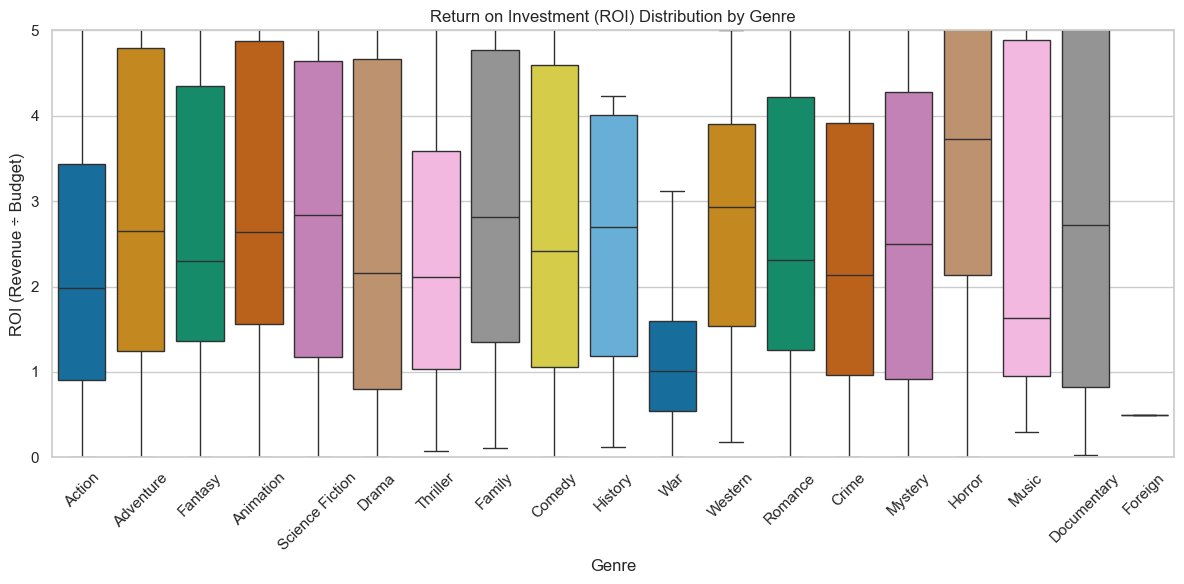

In [24]:
df = df.copy()
df = df[(df["budget"].notna()) & (df["revenue"].notna()) & (df["budget"] > 0)]

df["ROI"] = df["revenue"] / df["budget"]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df.dropna(subset=["primary_genre","ROI"]),
    x="primary_genre",
    y="ROI",
    hue="primary_genre",
    palette="colorblind"
)
plt.ylim(0,5)  
plt.title("Return on Investment (ROI) Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("ROI (Revenue ÷ Budget)")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  
plt.tight_layout()
plt.show()



ROI by genre (boxplot):
- Compares ROI = revenue ÷ budget across genres using a colorblind-safe palette; y-limits capped at 0–5 to reduce outlier distortion.
- Boxes summarize median and IQR; whiskers/outliers reveal variability in returns.
- Takeaway: Some genres show higher median ROI and tighter spread, suggesting more reliable profitability than others.


# Conclusions

## My initial hypothesis was:
Higher production budgets are associated with higher revenues but have a weak relationship with user ratings; additionally, director experience and genre influence both ratings and revenue patterns.

## What we found:

- Budgets vs. Revenues: The pair plot and bar charts confirm a strong positive correlation between budget and revenue. High-budget films tend to gross more money.

- Budgets vs. Ratings: The relationship between budget and vote_average is weak. Some low-budget films achieve high ratings, while many expensive productions cluster around average ratings.

- Time trends: Movie releases have steadily increased over the decades, with a surge in the 2000s. The stacked area chart shows genre preferences shifting over time, with action and adventure dominating recent years.

- Directors & Ratings: The violin plot shows that a handful of directors consistently achieve higher ratings, suggesting that director reputation/skill matters beyond budget.

- Genres: The bar chart of average budget vs. revenue by genre shows that action, adventure, and animation films typically command high budgets and deliver high revenues. In contrast, dramas and comedies operate on lower budgets and generate more modest returns.

- ROI (Return on Investment): The ROI analysis highlights that horror and thriller films, despite lower budgets, can achieve very high profitability, outperforming some blockbuster genres on a proportional basis.

- Correlations: The heatmap confirms revenue is strongly tied to budget, while vote_average (ratings) correlates only weakly with financial variables. Runtime shows little impact on success.

## Final Insights

- Hypothesis confirmed (partially): Budgets do drive revenues, but they do not guarantee better ratings.

- Director and genre play key roles in shaping both audience reception and financial performance.

- Unexpected finding: Smaller-budget genres like horror often achieve superior ROI, challenging the assumption that “bigger budget = better success.”

- A movie’s financial success is multi-dimensional: while budget matters for raw revenue, profitability and audience appreciation depend more on genre, storytelling, and creative direction.